<a href="https://colab.research.google.com/github/hajaulee/correcting-rotation-of-documents/blob/master/correcting_rotation_of_documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls -ial '/content/drive/My Drive/correcting-rotation-of-documents/test_dataset'

total 1470
53 -rw------- 1 root root 123223 Mar 17 05:01 0-pdf.jpg
44 -rw------- 1 root root  90604 Mar 16 14:56 0-the-cu-chi.jpg
42 -rw------- 1 root root 116900 Mar 16 14:56 0-viet-tay.jpg
41 -rw------- 1 root root  45636 Mar 16 14:45 0-vi.jpg
46 -rw------- 1 root root 113079 Mar 16 15:21 180-japan.jpg
52 -rw------- 1 root root 114850 Mar 17 05:01 180-pdf.jpg
47 -rw------- 1 root root 104953 Mar 16 15:34 180-the-cu-chi.jpg
48 -rw------- 1 root root 114676 Mar 16 15:35 180-viet-tay.jpg
54 -rw------- 1 root root 113704 Mar 17 05:01 270-pdf.jpg
49 -rw------- 1 root root 105561 Mar 16 15:35 270-the-cu-chi.jpg
50 -rw------- 1 root root 117317 Mar 16 15:35 270-viet-tay.jpg
51 -rw------- 1 root root 118880 Mar 17 05:01 90-pdf.jpg
43 -rw------- 1 root root 106081 Mar 16 14:56 90-the-cu-chi.jpg
45 -rw------- 1 root root 115443 Mar 16 15:18 90-viet-tay.jpg


In [3]:
import cv2 as cv
import glob
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.layers import Convolution2D, Dropout, Dense, Flatten, MaxPooling2D, Input, BatchNormalization, Add, GlobalAveragePooling2D
from keras.models import Model
from keras import applications
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import metrics, regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
working_path = '/content/drive/My Drive/correcting-rotation-of-documents'
image_shape = (200,200,1)
nb_classes = 4

In [0]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [0]:
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [0]:
def load_data(folder):
    X, labels, names = [],[], []
    list_images_file = glob.glob(os.path.join(folder, "*.jpg"))
    for filename in list_images_file:
        img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, image_shape[:2])
        img = np.asarray(img)
        img = img.reshape(image_shape)
        label = os.path.basename(filename)[0]
        X.append(img)
        labels.append(label)
        names.append(os.path.basename(filename))
#         print ('Loaded', filename)
    print("Loaded", len(list_images_file), 'files')
    return np.asarray(X), np.asarray(labels), names

In [0]:
def get_model(nb_classes):
    # size of pooling area for max pooling
    pool_size = (2, 2)
    # convolution kernel size
    kernel_size = (3,3)
    # convolution strides
    strides = (1,1)

    # model definition
    input = Input(shape=image_shape)
    
    x = Convolution2D(96, (3,3), strides=(2,2),
                      activation='relu')(input)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    
    
    x = Convolution2D(64, kernel_size, strides=strides,
                      activation='relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    x_cv1 = x
    
    x = Convolution2D(64, kernel_size, strides=strides,
                      activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, x_cv1])
#     x = Dropout(rate=0.40)(x)
    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
#     x = Dropout(rate=0.30)(x)
    x = Dense(80, activation='relu')(x)
#     x = Dropout(rate=0.70)(x)
    x = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=[input], outputs=x)

    model.summary()
    # model compilation
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [0]:
def get_resNet(nb_classes):
  base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= image_shape)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.7)(x)
  predictions = Dense(nb_classes, activation= 'softmax')(x)
  model = Model(inputs = base_model.input, outputs = predictions)
  model.summary()
  from keras.optimizers import SGD, Adam
  # sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
  adam = Adam(lr=0.0001)
  model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
#@title Trainning function { display-mode: "both" }

def train(model, train_, test_, nb_epoch=100, allow_early_stop=False):
    print('Train {} epochs, Allow early stopping: {}'.format(nb_epoch, allow_early_stop) )
    # training parameters
    batch_size = 200

    output_filename = 'model.json'
    # callbacks
    checkpointer = ModelCheckpoint(
        filepath=output_filename,
        save_best_only=True
    )
    early_stopping = EarlyStopping(patience=2)
    tensorboard = TensorBoard()

    callbacks = [checkpointer, tensorboard, early_stopping] if allow_early_stop else [checkpointer, tensorboard]
    # training loop
    with tf.device('/gpu:0'):
        histories = model.fit(train_[0], train_[1],
            epochs=nb_epoch,
            batch_size=125,
            validation_data=test_,
            verbose=True,
            shuffle=True,
            callbacks=callbacks
        )

    return model, histories

In [17]:
start_time = time.time()
# Build model
model = get_model(nb_classes)
# model = get_resNet(nb_classes)
build_model_time = time.time() - start_time
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 99, 99, 96)   960         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 49, 49, 64)   55360       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 24, 24, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [12]:
start_time = time.time()
images_path = os.path.join(working_path,'train_dataset')
print('Load images from', images_path)
X_data, Y_data, N_data = load_data(images_path)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=.2, random_state=42)

load_data_time = time.time() - start_time
print('Training with', len(X_train), 'images and validate with', len(X_test), 'images') 

Load images from /content/drive/My Drive/correcting-rotation-of-documents/train_dataset
Loaded 2156 files
Training with 1724 images and validate with 432 images


In [0]:
labelencoder_X = LabelEncoder()
Y_train = labelencoder_X.fit_transform(Y_train)
Y_test = labelencoder_X.transform(Y_test)

Y_train = indices_to_one_hot(Y_train, nb_classes)
Y_test = indices_to_one_hot(Y_test, nb_classes)

In [22]:
start_time = time.time()
model, history = train(model, train_=(X_train, Y_train), test_=(X_test, Y_test), nb_epoch=50)
train_model_time = time.time() - start_time
print("Training complete")

Train 50 epochs, Allow early stopping: False
Train on 1724 samples, validate on 432 samples
Epoch 1/50
1724/1724 [==============================] - 5s 3ms/step - loss: 4.7568e-04 - acc: 1.0000 - val_loss: 0.2812 - val_acc: 0.9375
Epoch 2/50
1724/1724 [==============================] - 5s 3ms/step - loss: 4.6937e-04 - acc: 1.0000 - val_loss: 0.2812 - val_acc: 0.9375
Epoch 3/50
1724/1724 [==============================] - 5s 3ms/step - loss: 4.5866e-04 - acc: 1.0000 - val_loss: 0.2812 - val_acc: 0.9375
Epoch 4/50
1724/1724 [==============================] - 5s 3ms/step - loss: 4.4326e-04 - acc: 1.0000 - val_loss: 0.2808 - val_acc: 0.9398
Epoch 5/50
1724/1724 [==============================] - 5s 3ms/step - loss: 4.5253e-04 - acc: 1.0000 - val_loss: 0.2806 - val_acc: 0.9375
Epoch 6/50
1724/1724 [==============================] - 5s 3ms/step - loss: 4.2605e-04 - acc: 1.0000 - val_loss: 0.2817 - val_acc: 0.9375
Epoch 7/50
1724/1724 [==============================] - 5s 3ms/step - loss: 4.19

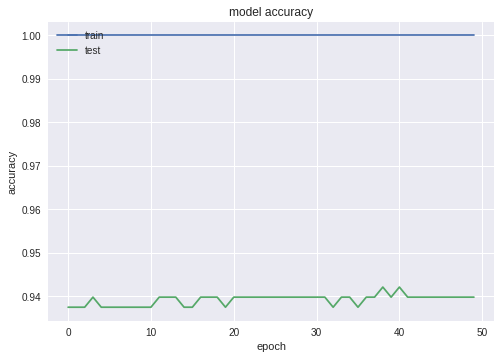

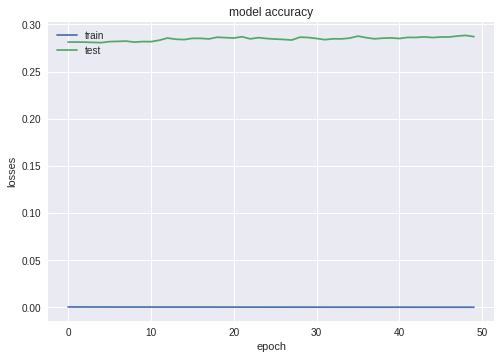

432/432 [==============================] - 0s 1ms/step
Evaluate model: loss:0.2869387187615589, acc:0.9398148148148148
Build model in 0.5186648368835449 seconds.
Load data in 54.04591727256775 seconds.
Train model in 238.59462451934814 second.
Max val_acc is 0.9421296328030251 at epoch 39


In [23]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Evaluate model: loss:{}, acc:{}".format(test_loss, test_acc))
print("Build model in {} seconds.".format(build_model_time))
print("Load data in {} seconds.".format(load_data_time))
print("Train model in {} second.".format(train_model_time))
print("Max val_acc is {} at epoch {}".format(max(history.history['val_acc']), 
      1 + np.where(history.history['val_acc'] ==max(history.history['val_acc']))[0][0]))

In [24]:
print("Label:",Y_test[1])
tmp_test = np.expand_dims(X_test[1], axis=0)
print("Predict:",model.predict(tmp_test))

real_data = load_data(os.path.join(working_path,'test_dataset'))

real_labels = indices_to_one_hot(labelencoder_X.transform(real_data[1]), nb_classes)

print(np.expand_dims(np.asarray(real_data[2]), axis=1))
print("Real data label:\n", real_labels)
predicted_result = model.predict(real_data[0])
hot_results = []

for row in predicted_result:
    hot_index = np.where(row == max(row))[0][0]
    hot_result = [0] * len(row)
    hot_result[hot_index] = 1
    hot_results.append(hot_result)
hot_results = np.asarray(hot_results)
print("Real data Predict:\n", hot_results)

real_test_loss, real_test_acc = model.evaluate(real_data[0], real_labels)
print("Evaluate model: loss:{}, acc:{}".format(real_test_loss, real_test_acc))

Label: [1. 0. 0. 0.]
Predict: [[9.9999762e-01 1.5628477e-06 7.4649046e-07 3.9153310e-08]]
Loaded 14 files
[['0-vi.jpg']
 ['0-viet-tay.jpg']
 ['90-the-cu-chi.jpg']
 ['0-the-cu-chi.jpg']
 ['90-viet-tay.jpg']
 ['180-japan.jpg']
 ['180-the-cu-chi.jpg']
 ['180-viet-tay.jpg']
 ['270-the-cu-chi.jpg']
 ['270-viet-tay.jpg']
 ['90-pdf.jpg']
 ['180-pdf.jpg']
 ['0-pdf.jpg']
 ['270-pdf.jpg']]
Real data label:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
Real data Predict:
 [[1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]]
14/14 [==============================] - 0s 2ms/step
Evaluate model: loss:0.9190641045570374, acc:0.7142857313156128


In [0]:
!git remote